# Titanic: problema de clasificación

### The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.  
In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### What Data Will I Use in This Competition?
In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled *train.csv* and the other is titled *test.csv*.  
- Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.  
- The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.  
Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived. Check out the “Data” tab to explore the datasets even further. Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.

### Submission File Format:  
You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond *PassengerId* and *Survived*) or rows. The file should have exactly 2 columns:
- **PassengerId** (sorted in any order)
- **Survived** (contains your binary predictions: 1 for survived, 0 for deceased)

## Cargando

In [203]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy
from matplotlib import pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Metricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

/Users/julianquintana/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [104]:
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [105]:
# Transformador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [106]:
# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

In [107]:
train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [108]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [109]:
train.shape

(891, 12)

In [110]:
class_names = {0:'Fallecido', 1:'Sobreviviente'}
print(train.Survived.value_counts().rename(index = class_names))

Survived
Fallecido        549
Sobreviviente    342
Name: count, dtype: int64


In [111]:
# Visualizamos los tipos de cada uno de los atributos
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [112]:
# Comprobamos si alguna columna tiene valores nulos
train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [127]:
Y = train["Survived"]
X = train.loc[:, train.columns != 'Survived']
X = X.loc[:, X.columns != ('Name')]
X = X.loc[:, X.columns != 'Ticket']
X = X.loc[:, X.columns != 'Age']
X = X.loc[:, X.columns != 'Fare']
X = X.loc[:, X.columns != 'Cabin']
X = X.loc[:, X.columns != 'Embarked']
X.set_index('PassengerId', inplace=True)

In [128]:
X.head()

,Pclass,Sex,SibSp,Parch
PassengerId,,,,
1,3,male,1,0
2,1,female,1,0
3,3,female,0,0
4,1,female,1,0
5,3,male,0,0


In [129]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [130]:
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (891, 4)
Shape of Y: (891,)


In [131]:
print("Columns of X:", X.columns)

Columns of X: Index(['Pclass', 'Sex', 'SibSp', 'Parch'], dtype='object')


### Preparación y escalado del conjunto de datos

In [132]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [133]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X)

/Users/julianquintana/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


DataFramePreparer()

In [137]:
X_prep = data_preparer.transform(X)

In [138]:
X_prep.head()

,Pclass,SibSp,Parch,Sex_female,Sex_male
PassengerId,,,,,
1,0.0,1.0,0.0,0.0,1.0
2,-2.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,-2.0,1.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0


## Regresión logística

In [163]:
LG = LogisticRegression()
LG.fit(X = X_prep, y = Y)

LogisticRegression()

In [164]:
# Accuracy de test del modelo 
# ==============================================================================
Y_pred = LG.predict(X = X_prep)

print(accuracy_score(Y, Y_pred))

0.8002244668911336


In [165]:
LR_accu = accuracy_score(Y, Y_pred)

### Matriz de confusión y métricas derivadas de esta

In [166]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(Y, Y_pred)
cm

array([[483,  66],
       [112, 230]])

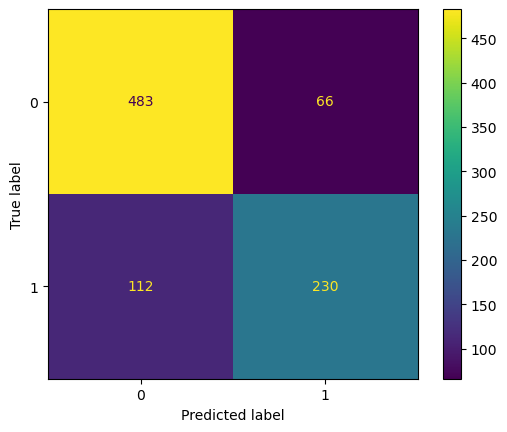

In [167]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LG.classes_)
disp.plot()

In [168]:
from sklearn.metrics import precision_score

print("Precisión:", precision_score(Y, Y_pred))

Precisión: 0.777027027027027


In [169]:
from sklearn.metrics import recall_score

print("Recall:", recall_score(Y, Y_pred))

Recall: 0.672514619883041


In [170]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(Y, Y_pred))

F1 score: 0.7210031347962382


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


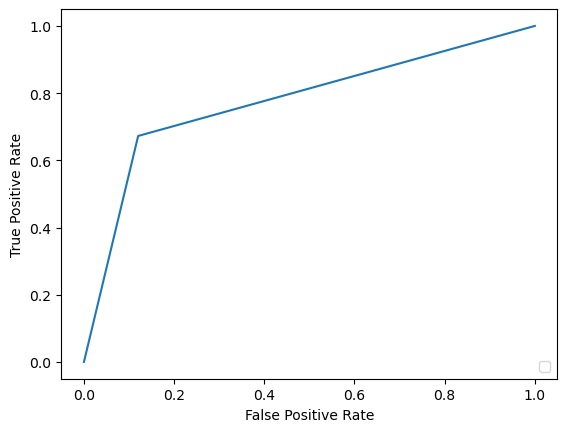

In [171]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y, Y_pred, pos_label=LG.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

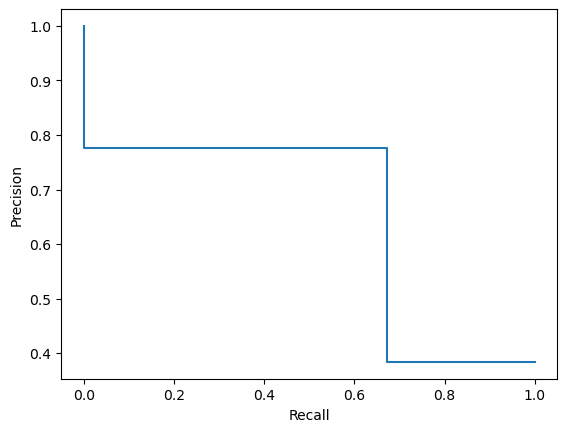

In [172]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(Y, Y_pred, pos_label=LG.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

## Máquina de soporte vectorial

In [173]:
model_SVC = SVC()
model_SVC.fit(X_prep, Y)

SVC()

In [174]:
# Accuracy de test del modelo

Y_pred = model_SVC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8058361391694725


In [175]:
SVM_accu = accuracy_score(Y, Y_pred)

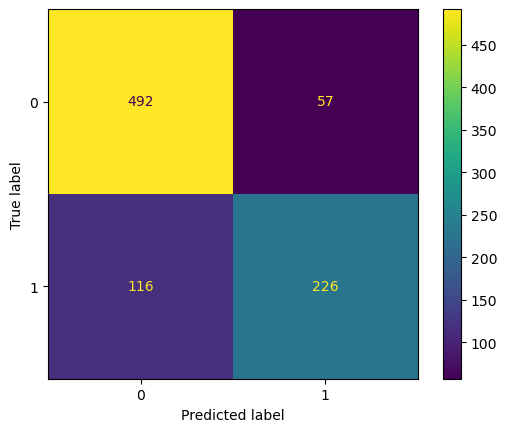

In [176]:
cm=confusion_matrix(Y, Y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_SVC.classes_)
disp.plot()

## Árbol de decisión

In [178]:
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_prep, Y)

DecisionTreeClassifier()

In [179]:
# Accuracy de test del modelo 

Y_pred = model_DTC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8170594837261503


In [180]:
DT_accu = accuracy_score(Y, Y_pred)

## Random forest

In [182]:
model_RFC = RandomForestClassifier()
model_RFC.fit(X_prep, Y)

RandomForestClassifier()

In [183]:
# Accuracy de test del modelo 

Y_pred = model_RFC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8170594837261503


In [185]:
RF_accu = accuracy_score(Y, Y_pred)

## AdaBoost

In [186]:
model_ABC = AdaBoostClassifier()
model_ABC.fit(X_prep, Y)

AdaBoostClassifier()

In [187]:
# Accuracy de test del modelo 

Y_pred = model_ABC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8013468013468014


In [189]:
ADA_accu = accuracy_score(Y, Y_pred)

## Modelo Extra trees

In [190]:
model_ETC = ExtraTreesClassifier()
model_ETC.fit(X_prep, Y)

ExtraTreesClassifier()

In [191]:
# Accuracy de test del modelo 

Y_pred = model_ETC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8170594837261503


In [194]:
ETC_accu = accuracy_score(Y, Y_pred)

## Gradient Boosting

In [195]:
model_GBC = GradientBoostingClassifier()
model_GBC.fit(X_prep, Y)

GradientBoostingClassifier()

In [196]:
# Accuracy de test del modelo 

Y_pred = model_GBC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8159371492704826


In [198]:
GB_accu = accuracy_score(Y, Y_pred)

## K-Nearest Neighbors

In [199]:
model_KNC = KNeighborsClassifier()
model_KNC.fit(X_prep, Y)

KNeighborsClassifier()

In [200]:
# Accuracy de test del modelo 

Y_pred = model_KNC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8103254769921436


In [202]:
KNN_accu = accuracy_score(Y, Y_pred)

## Light GBM

In [204]:
model_LGBMC = lightgbm.LGBMClassifier()
model_LGBMC.fit(X_prep, Y)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier()

In [205]:
# Accuracy de test del modelo 

Y_pred = model_LGBMC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8125701459034792


In [206]:
lgbmc_accu = accuracy_score(Y, Y_pred)

## Naive Bayes

In [207]:
model_NB = BernoulliNB()
model_NB.fit(X_prep, Y)

BernoulliNB()

In [208]:
# Accuracy de test del modelo 

Y_pred = model_NB.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.7867564534231201


In [210]:
NB_accu = accuracy_score(Y, Y_pred)

## XGBoost

In [212]:
model_XGBC = xgb.XGBClassifier()
model_XGBC.fit(X_prep, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [213]:
# Accuracy de test del modelo 

Y_pred = model_XGBC.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.8159371492704826


In [214]:
XGB_accu = accuracy_score(Y, Y_pred)

## LDA

In [215]:
model_LDA = LinearDiscriminantAnalysis()
X_lda=model_LDA.fit(X_prep, Y)

In [216]:
# Accuracy de test del modelo 

Y_pred = model_LDA.predict(X=X_prep)
print(accuracy_score(Y, Y_pred))

0.7912457912457912


In [217]:
LDA_accu = accuracy_score(Y, Y_pred)

## Comparación de modelos

Text(0.5, 1.0, 'Comparación de modelos')

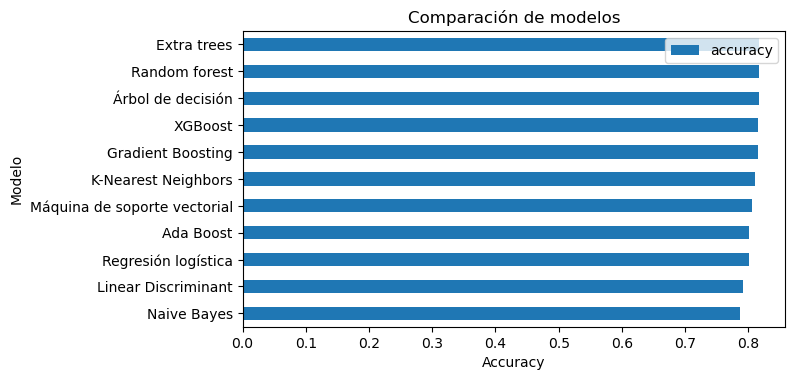

In [218]:
df_comparacion = pd.DataFrame({
                    'modelo': ['Regresión logística', 'Máquina de soporte vectorial','Árbol de decisión', 'Random forest', 'Ada Boost', 'Extra trees', 'Gradient Boosting', 'K-Nearest Neighbors', 'Naive Bayes', 'XGBoost', 'Linear Discriminant'],
                    'accuracy': [LR_accu, SVM_accu, DT_accu, RF_accu, ADA_accu, ETC_accu, GB_accu, KNN_accu, NB_accu, XGB_accu, LDA_accu]
                 })
df_comparacion = df_comparacion.sort_values('accuracy', ascending=True)
fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de modelos')